<a href="https://colab.research.google.com/github/fahernkhan/klasifikasi-kucing-dan-kelinci-deploy-tflite/blob/main/kucing%20dan%20kelinci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import zipfile

In [ ]:
from google.colab import files
files.upload()

Saving catrabit.zip to catrabit.zip


In [ ]:
import zipfile,os
local_zip = '/content/catrabit.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()



In [ ]:
!mv /content/test-images/cat* /content/train-cat-rabbit/cat

In [ ]:
!mv /content/test-images/rabbit* /content/train-cat-rabbit/rabbit

In [ ]:
pip install split-folders


In [ ]:
# Mendefinisikan nama direktori untuk data train dan data val
import splitfolders
base_dir = "/content/cat-rabbit"
splitfolders.ratio(base_dir, output = "/content/catrabbit", seed=42, ratio = (.8, .2))
train_dir = os.path.join("/content/catrabbit","train")
validation_dir = os.path.join("/content/catrabbit","val")

Copying files: 1605 files [00:00, 7321.69 files/s]


In [ ]:
# Mengatur untuk train
train_cat_is = os.path.join(train_dir, 'cat')
train_rabbit_is = os.path.join (train_dir, 'rabbit')


# Mengatur untuk val
valid_cat_is = os.path.join(validation_dir,'cat')
valid_rabbit_is = os.path.join (validation_dir, 'rabbit')

In [ ]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  # direktori data latih
        target_size =(150,150),
        batch_size=32,
        # karena ini merupakan masalah klasifikasi 2 kelas gunakan class_mode = 'binary'
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir, # direktori data validasi
        target_size =(150,150),
        batch_size=32, 
        # karena ini merupakan masalah klasifikasi 2 kelas gunakan class_mode = 'binary'
        class_mode='binary')

Found 1284 images belonging to 2 classes.
Found 321 images belonging to 2 classes.


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
# compile model dengan 'adam' optimizer loss function 'binary_crossentropy' 
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
#callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.90 and logs.get('val_accuracy')>0.90):
      print("\nAccuracy above 90%, finish training!")
      self.model.stop_training = True

callbacks = myCallback()


In [ ]:
# Proses Training 
batch_size = 32
history = model.fit(train_generator, 
                    epochs =  10, 
                    steps_per_epoch = 1284//batch_size, 
                    validation_data = validation_generator, 
                    verbose = 2, 
                    validation_steps = 321//batch_size,
                    callbacks =[callbacks])

Epoch 1/10
40/40 - 68s - loss: 0.2420 - accuracy: 0.9002 - val_loss: 0.3437 - val_accuracy: 0.8438 - 68s/epoch - 2s/step
Epoch 2/10
40/40 - 73s - loss: 0.2483 - accuracy: 0.8970 - val_loss: 0.3188 - val_accuracy: 0.8438 - 73s/epoch - 2s/step
Epoch 3/10
40/40 - 68s - loss: 0.1934 - accuracy: 0.9241 - val_loss: 0.2369 - val_accuracy: 0.8969 - 68s/epoch - 2s/step
Epoch 4/10
40/40 - 69s - loss: 0.2419 - accuracy: 0.8930 - val_loss: 0.3273 - val_accuracy: 0.8625 - 69s/epoch - 2s/step
Epoch 5/10
40/40 - 68s - loss: 0.1791 - accuracy: 0.9281 - val_loss: 0.3400 - val_accuracy: 0.8625 - 68s/epoch - 2s/step
Epoch 6/10
40/40 - 73s - loss: 0.1766 - accuracy: 0.9297 - val_loss: 0.2821 - val_accuracy: 0.8875 - 73s/epoch - 2s/step
Epoch 7/10
40/40 - 70s - loss: 0.1628 - accuracy: 0.9312 - val_loss: 0.3247 - val_accuracy: 0.8500 - 70s/epoch - 2s/step
Epoch 8/10

Accuracy above 90%, finish training!
40/40 - 68s - loss: 0.1907 - accuracy: 0.9265 - val_loss: 0.2420 - val_accuracy: 0.9125 - 68s/epoch - 2s

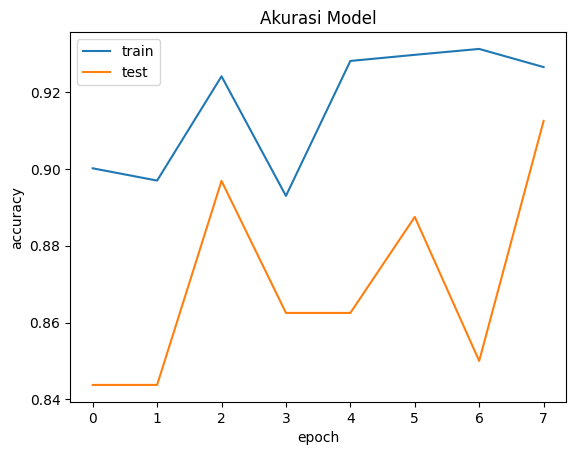

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

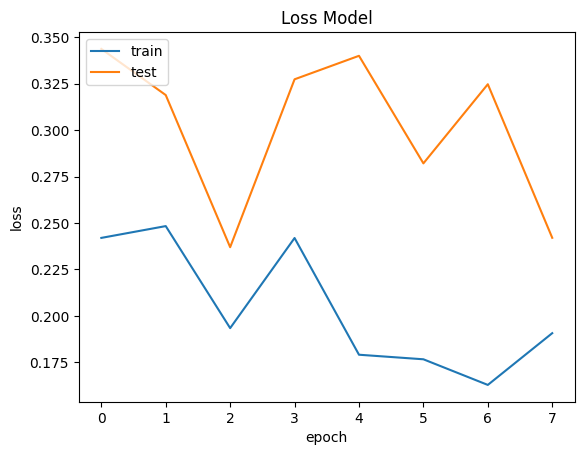

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Konversi model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)
 

In [ ]:
#save model
model.save('my_model.pb') 
%cd